In [1]:
import pandas as pd
import numpy as np

# Read the cleaned file into a DataFrame
df = pd.read_csv('../data/bgg_rating_threshold.csv', sep=';', engine='c')

# Convert the 'bgg_user_rating' column to numeric
df['bgg_user_rating'] = ((pd.to_numeric(df['bgg_user_rating'], errors='coerce'))*10).astype(np.uint8)

print("done")

done


In [2]:
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
data = list(df.itertuples(index=False, name=None))
# Alternatively, you can use df['item'], df['user'], and df['review_score'] directly.

# Create unique mappings for items and users
unique_items = sorted(df['bgg_id'].unique())
unique_users = sorted(df['bgg_user_name'].unique())

item_to_index = {item: idx for idx, item in enumerate(unique_items)}
user_to_index = {user: idx for idx, user in enumerate(unique_users)}

# Prepare row indices, column indices, and data (review scores) using the DataFrame columns
rows = df['bgg_id'].map(item_to_index)
cols = df['bgg_user_name'].map(user_to_index)
scores = df['bgg_user_rating']

# Create a sparse matrix using the COO format:
sparse_matrix = coo_matrix(
    (scores, (rows, cols)),
    shape=(len(unique_items), len(unique_users))
)

# Optionally convert to CSR format for more efficient arithmetic operations
sparse_matrix = sparse_matrix.tocsr()
print ("Sparse matrix created with shape:", sparse_matrix.shape)

Sparse matrix created with shape: (15738, 411956)


In [3]:
import csv

# Write the unique_items list to a CSV file
with open('../data/bgg_id.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([[item] for item in unique_items])

In [4]:
# Normalize data
# 1. Compute row (user) means
user_means = sparse_matrix.mean(axis=1)

# 2. Subtract row means to center (memory-efficient way)
from scipy.sparse import diags

# Create a diagonal matrix of user means
user_means_diag = diags(user_means.A.flatten())

# Subtract the user means from the sparse matrix
centered_sparse = sparse_matrix - user_means_diag @ sparse_matrix

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity matrix
cosine_similarity_matrix = cosine_similarity(centered_sparse)

print("Cosine similarity matrix calculated with shape:", cosine_similarity_matrix.shape)

Cosine similarity matrix calculated with shape: (15738, 15738)


In [6]:
# Set all values in cosine_similarity_matrix below 0.2 to 0
cosine_similarity_matrix[(cosine_similarity_matrix < 0.2)] = 0

In [7]:
from scipy.sparse import csr_matrix

# Convert the cosine similarity matrix to a sparse matrix
sim_sparse_matrix = csr_matrix(cosine_similarity_matrix)

print("Sparse matrix created from cosine similarity matrix with shape:", sim_sparse_matrix.shape)

Sparse matrix created from cosine similarity matrix with shape: (15738, 15738)


In [8]:
# sim_df = pd.DataFrame(cosine_similarity_matrix, 
#                           index=unique_items, 
#                           columns=unique_items)

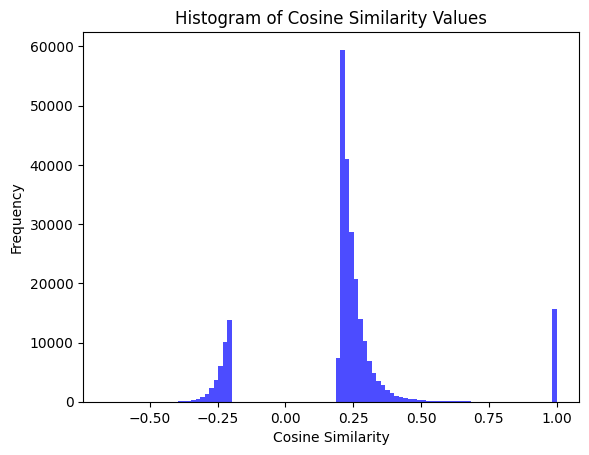

In [9]:
import matplotlib.pyplot as plt

# Create a histogram
flattened = cosine_similarity_matrix.flatten()
plt.hist(np.delete(flattened,np.where(flattened==0)), bins=100, color='blue', alpha=0.7)
plt.title("Histogram of Cosine Similarity Values")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [9]:
import networkx as nx

import scipy.sparse as sp
import networkx as nx
from networkx.convert_matrix import from_scipy_sparse_array

G = from_scipy_sparse_array(
    sim_sparse_matrix,
    create_using=nx.Graph(),
    edge_attribute='weight'
)

    # 3. Relabel nodes if labels provided
    
mapping = dict(enumerate(unique_items))
G = nx.relabel_nodes(G, mapping)


In [ ]:
from networkx import community
communities2 = community.louvain_communities(G, weight='weight')
communities = {}
for i, community in enumerate(communities2):
    for node in community:
        communities[node] = i

# Map node_community values to the corresponding nodes in coords
communities = [communities[node] for node in sorted(G.nodes())]

In [31]:
import leidenalg
import igraph as ig
H=ig.Graph.from_networkx(G)
communities = leidenalg.find_partition(H, leidenalg.ModularityVertexPartition,n_iterations=10).membership


In [ ]:
#partition_list = [(mapping[node], partition) for node, partition in enumerate(communities.membership)]
#print(partition_list)

In [32]:
import umap
reducer = umap.UMAP()
coords = reducer.fit_transform(cosine_similarity_matrix)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/tmp/ipykernel_6035/2172764468.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10', len(unique_communities))


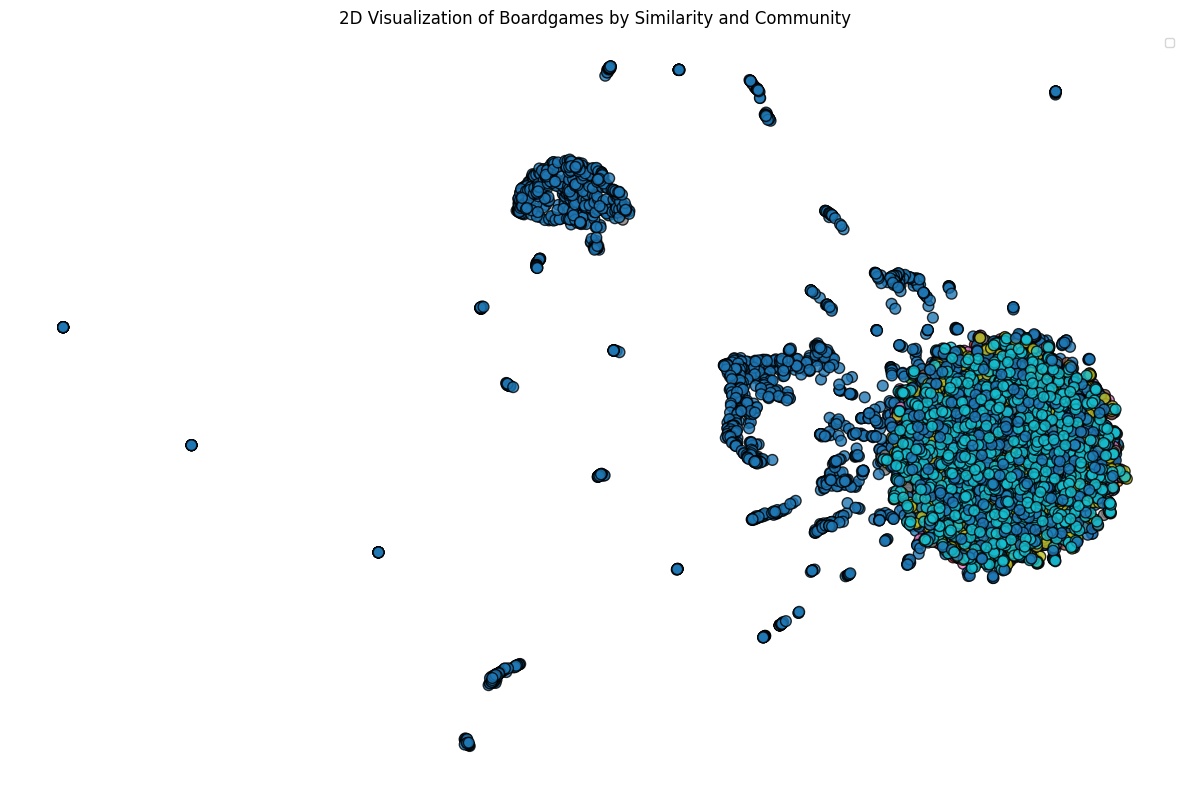

In [ ]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# Step 5: Plotting
plt.figure(figsize=(12, 8))
unique_communities = set(communities)
cmap = get_cmap('tab10', len(unique_communities))



plt.scatter(coords[:, 0], coords[:, 1], c=communities, cmap=cmap, s=60, alpha=0.8, edgecolor='k')

# Add legend without duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

plt.title("2D Visualization of Boardgames by Similarity and Community")
plt.axis('off')
plt.tight_layout()
plt.show()